# 3 - Create activations
- categories: [jupyter, activations]

## DATASETS:
(a) Carbonic Anhydrase II (ChEMBL205), a protein lyase,  
(b) Cyclin-dependent kinase 2 (CHEMBL301), a protein kinase,  
(c) ether-a-go-go-related gene potassium channel 1 (HERG) (CHEMBL240), a voltage-gated ion channel,  
(d) Dopamine D4 receptor (CHEMBL219), a monoamine GPCR,  
(e) Coagulation factor X (CHEMBL244), a serine protease,  
(f) Cannabinoid CB1 receptor (CHEMBL218), a lipid-like GPCR and  
(g) Cytochrome P450 19A1 (CHEMBL1978), a cytochrome P450.  
The activity classes were selected based on data availability and as representatives of therapeutically important target classes or as anti-targets.

In this notebook we will create an fastai cnn learner on the same dataset as in the last notebook and then extract the second to last layer with a so called hook. We can then apply the activations from this layer to every image in the dataset. In the next notebook we will use these activations to hopefully better the performance of our Random Forest model. 

In [1]:
#hide
top_mcc_scores = {
    
    'CHEMBL205': 0.862,
    'CHEMBL301': 0.926,
    'CHEMBL240': 0.884,
    'CHEMBL219': 0.887,
    'CHEMBL244': 0.983,
    'CHEMBL218': 0.941,
    'CHEMBL1978': 0.904}

In [2]:
#hide
!nvidia-smi

Mon Apr 26 14:44:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000        On   | 00000000:00:05.0 Off |                  Off |
| 42%   70C    P0   139W / 180W |   2789MiB / 16278MiB |     95%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#hide
import pandas as pd
import numpy as np
from pathlib import Path

In [4]:
dataset='CHEMBL205_cl'

In [5]:
#hide
path = Path('dataset/13321_2017_226_MOESM1_ESM/')
df = pd.read_csv(path/f'{dataset}.csv')

In [6]:
#hide
list(path.iterdir())

[PosixPath('dataset/13321_2017_226_MOESM1_ESM/CHEMBL205_cl_ecfp_1024.csv'),
 PosixPath('dataset/13321_2017_226_MOESM1_ESM/CHEMBL205_cl.csv'),
 PosixPath('dataset/13321_2017_226_MOESM1_ESM/mol_images')]

# Generate activations

In [7]:
IMAGES=path/'mol_images'/f'{dataset}'

## Create train validation split

In [8]:
#hide
from sklearn.model_selection import train_test_split

In [9]:
def get_df(data):
    
    name = data.stem
    
    df = pd.read_csv(data)
    df['Image'] = df['CID'].apply(lambda x: f'{str(x)}.png')
    
    df = df[['CID', 'SMILES', 'Image', 'Activity']]
    
    return df, name

In [10]:
x_train,x_val = train_test_split(df.index, test_size=0.25, stratify=df['Activity'], 
                                     random_state=42)
df.loc[x_train, 'is_valid']=False
df.loc[x_val, 'is_valid']=True

## Create dataloader

In [11]:
#hide
from fastai.vision.all import *

In [12]:
df['Image'] = df['CID'] + '.png'
df.head()

,CID,SMILES,Activity,is_valid,Image
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,1,True,CHEMBL188002.png
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,1,False,CHEMBL364127.png
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,1,False,CHEMBL1683469.png
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],1,False,CHEMBL52564.png
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,1,False,CHEMBL21427.png


In [13]:
db = DataBlock(
    blocks = (ImageBlock(), CategoryBlock()), 
    get_x=ColReader('Image', pref=IMAGES),
    get_y=ColReader('Activity'), 
    splitter=ColSplitter('is_valid'),
    item_tfms=None, 
    batch_tfms=None
    )

In [14]:
dls = db.dataloaders(df, bs=64, shuffle_train=True)

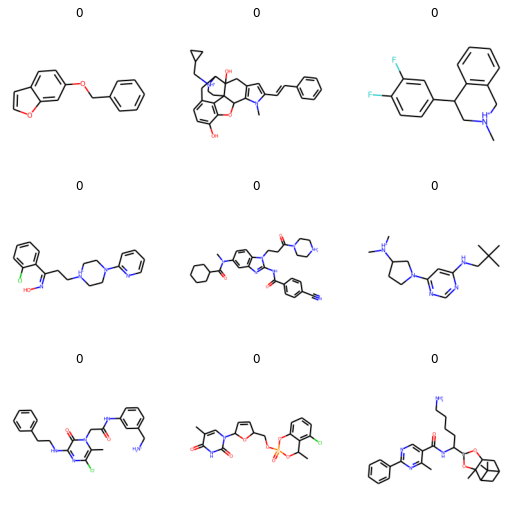

In [15]:
dls.show_batch()

# Train CNN model

In [16]:
#hide
from sklearn.metrics import auc,roc_auc_score,recall_score,precision_score,f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score

In [17]:
def train_model(dls, arch=resnet18, epochs=6, freeze_epochs=5, wd=None):
    
    print(f'Training model on dataset: {dataset}')
    print(f'Architechture: {arch}')
    print(f'Untrained epochs: freeze_epochs={freeze_epochs}')
    print(f'Trained epochs: epochs={epochs}')
    
    learn = cnn_learner(dls, arch=resnet18, pretrained=True, 
                            wd=wd,
                            metrics=[accuracy, 
                            F1Score(), 
                            Precision(), 
                            Recall(), 
                            RocAucBinary(), 
                            MatthewsCorrCoef()])
    
    
    print(f'Finding learning rate...')
    lr_min, lr_steep = learn.lr_find(suggestions=True, show_plot=False)
    print(f'Training model with learning rate: {lr_min}')
    learn.fine_tune(epochs, lr_min, freeze_epochs=freeze_epochs)
    
    return learn

In [18]:
# Train model on resnet18
learn = train_model(dls)

Training model on dataset: CHEMBL205_cl
Architechture: <function resnet18 at 0x7fe49bb13b80>
Untrained epochs: freeze_epochs=5
Trained epochs: epochs=6
Finding learning rate...


Training model with learning rate: 0.02089296132326126


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.297757,0.182952,0.932234,0.600000,0.647727,0.558824,0.920301,0.565033,01:03
1,0.206005,0.156396,0.948506,0.674189,0.794020,0.585784,0.944888,0.655752,01:03
2,0.196921,0.130718,0.955194,0.733775,0.798271,0.678922,0.972067,0.712261,01:01
3,0.158815,0.129715,0.962996,0.788265,0.821809,0.757353,0.977929,0.768798,01:03
4,0.142770,0.114239,0.951404,0.686782,0.829861,0.585784,0.978075,0.673090,01:02


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.128076,0.158720,0.948952,0.667634,0.818505,0.563725,0.944693,0.654097,01:22
1,0.133582,0.115550,0.963888,0.817156,0.757322,0.887255,0.977314,0.800337,01:26
2,0.117920,0.097336,0.963665,0.799508,0.802469,0.796569,0.978159,0.779537,01:20
3,0.089624,0.108425,0.956531,0.720230,0.868512,0.615196,0.984091,0.709611,01:21
4,0.052601,0.089789,0.969015,0.831515,0.822542,0.840686,0.985702,0.814515,01:20
5,0.029035,0.105855,0.970129,0.835381,0.837438,0.833333,0.983640,0.818958,00:49


In [19]:
#hide
interp = ClassificationInterpretation.from_learner(learn)

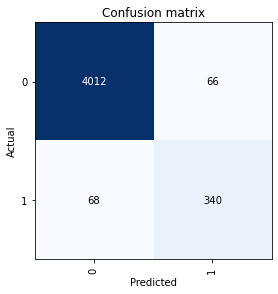

In [20]:
interp.plot_confusion_matrix()

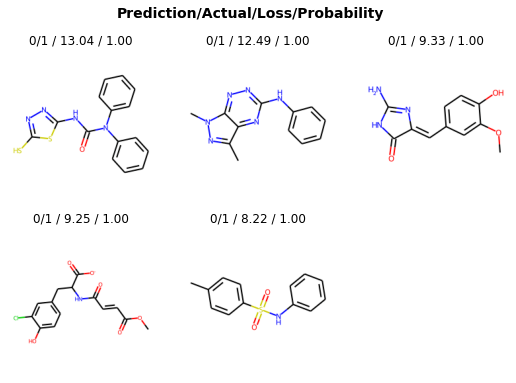

In [21]:
interp.plot_top_losses(k=5)

# Hook the activations from the second last layer

In [22]:
# Hook function
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [23]:
#hide
learn.model[-1][-5]

Linear(in_features=1024, out_features=512, bias=False)

In [24]:
hook_output = Hook()
hook = learn.model[-1][-5].register_forward_hook(hook_output.hook_func)

In [25]:
#hide
df_nodupl=df

In [26]:
test_db = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),
    get_x=ColReader('Image', pref=IMAGES),
    get_y=ColReader('Activity'),
    splitter=RandomSplitter(valid_pct=0.),
    item_tfms=None,
    batch_tfms=None
    )

In [27]:
test_dls = test_db.dataloaders(df_nodupl, bs=1)

In [28]:
test_dls.items.head()

,CID,SMILES,Activity,is_valid,Image
14250,CHEMBL239935,[nH]1c2c3c(nnc2c2c1cccc2)cccc3,0,False,CHEMBL239935.png
9720,CHEMBL1997503,Clc1cc(ccc1OC(C)C)-c1nc(on1)-c1ccc(NC2CC(CC2)C(=O)[O-])cc1,0,False,CHEMBL1997503.png
9468,CHEMBL257293,Fc1ccc(cc1)CC1CCC[NH+](C1)C(O)CC(NC(=O)Nc1cc(cc(c1)C(C)C)-c1nnnn1C)C,0,False,CHEMBL257293.png
5423,CHEMBL478611,O1CC(O)(Cc2cc(O)c(O)cc2)C(O)c2c1c(O)c(O)cc2,0,False,CHEMBL478611.png
14108,CHEMBL111872,n1c(Cc2ccccc2)c(n(C)c1N)Cc1ccccc1,0,True,CHEMBL111872.png


In [29]:
#hide
test_dls.dataset[0]

(PILImage mode=RGB size=224x224, TensorCategory(0))

In [30]:
#hide
test_df = test_dls.items.reset_index()

In [31]:
#hide
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     17941 non-null  int64 
 1   CID       17941 non-null  object
 2   SMILES    17941 non-null  object
 3   Activity  17941 non-null  int64 
 4   is_valid  17941 non-null  object
 5   Image     17941 non-null  object
dtypes: int64(2), object(4)
memory usage: 841.1+ KB


In [32]:
#hide
df_nodupl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   CID       17941 non-null  object
 1   SMILES    17941 non-null  object
 2   Activity  17941 non-null  int64 
 3   is_valid  17941 non-null  object
 4   Image     17941 non-null  object
dtypes: int64(1), object(4)
memory usage: 700.9+ KB


In [33]:
#hide
test_df.loc[test_df.CID == 'CHEMBL1089637']

,index,CID,SMILES,Activity,is_valid,Image
9865,1403,CHEMBL1089637,S(=O)(=O)(N)c1ccc(NC2OCC(O)C(O)C2O)cc1,1,False,CHEMBL1089637.png


In [34]:
#hide
df_nodupl.loc[df_nodupl.CID == 'CHEMBL1089637']

,CID,SMILES,Activity,is_valid,Image
1403,CHEMBL1089637,S(=O)(=O)(N)c1ccc(NC2OCC(O)C(O)C2O)cc1,1,False,CHEMBL1089637.png


In [35]:
#hide
test_dls.dataset

(#17941) [(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0))...]

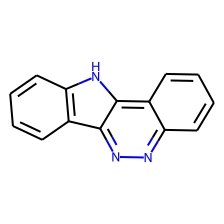

In [36]:
#hide
test_dls.dataset[0][0]

In [37]:
#hide
test_df.loc[test_df.CID=='CHEMBL1089637']

,index,CID,SMILES,Activity,is_valid,Image
9865,1403,CHEMBL1089637,S(=O)(=O)(N)c1ccc(NC2OCC(O)C(O)C2O)cc1,1,False,CHEMBL1089637.png


In [38]:
#hide
def get_data(CID):
    idx = test_df.loc[test_df.CID==CID].index[0]
    print(idx)
    return test_dls.dataset[idx]

In [39]:
#hide
t_img, t_cat = get_data('CHEMBL1089637')

9865


In [40]:
#hide
len(test_dls.dataset)

17941

In [41]:
#hide
test_dls.dataset[0]

(PILImage mode=RGB size=224x224, TensorCategory(0))

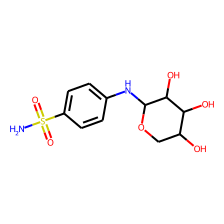

In [42]:
#hide
t_img

Defining the function for getting activations of a single image in the dataset

In [43]:
df_nodupl['activations'] = None

In [44]:
def get_activations(CID, ret=False):
    idx = df_nodupl.loc[df_nodupl.CID == CID].index[0]
    print(idx)
    data = get_data(CID)
    img = data[0]
    with torch.no_grad(): 
        output = learn.predict(img)
    acts = np.array(hook_output.stored.cpu())[0]
    #df_nodupl.iloc[idx]['acts'] = list(acts)
    if not ret: 
        df_nodupl.at[idx, 'activations'] = list(acts)
    if ret: 
        return list(acts)

In [45]:
#hide
df_nodupl.CID.values[0]

'CHEMBL188002'

Getting 512 activations for every image in the dataframe and adding it as a single column

In [46]:
%%capture
for CID in df_nodupl.CID.values:
    get_activations(CID)

In [49]:
#hide
df_nodupl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CID          17941 non-null  object
 1   SMILES       17941 non-null  object
 2   Activity     17941 non-null  int64 
 3   is_valid     17941 non-null  object
 4   Image        17941 non-null  object
 5   activations  17941 non-null  object
dtypes: int64(1), object(5)
memory usage: 841.1+ KB


Splitting each activation to its own column in the dataframe

In [50]:
df_acts = pd.concat([df_nodupl, pd.DataFrame(df_nodupl.activations.values.tolist()).add_prefix('act_')], axis=1)

In [51]:
df_acts.drop('activations', axis=1, inplace=True)

In [52]:
df_acts.head()

,CID,SMILES,Activity,is_valid,Image,act_0,act_1,act_2,act_3,act_4,...,act_502,act_503,act_504,act_505,act_506,act_507,act_508,act_509,act_510,act_511
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,1,True,CHEMBL188002.png,-42.897369,34.907032,-35.413910,-21.410141,-61.686359,...,98.090538,-40.475765,-55.758678,-40.196342,-21.565161,-39.386112,88.342987,-77.520561,30.948782,-48.423111
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,1,False,CHEMBL364127.png,-96.240280,17.625538,46.354603,-167.131653,-92.642540,...,105.425598,-53.179356,-1.957846,-152.047241,-124.394402,-114.585510,123.068222,-48.347355,94.419861,-130.973587
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,1,False,CHEMBL1683469.png,-110.437485,1.140767,84.031761,-205.667786,-99.510849,...,102.208374,-64.332008,33.721348,-192.948685,-178.112000,-143.599503,147.062531,-47.969799,126.356018,-158.886963
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],1,False,CHEMBL52564.png,-42.642754,18.759075,5.093142,-42.919945,-57.405197,...,105.915039,-39.527615,-23.374825,-81.049446,-53.409107,-57.353622,98.793694,-46.956039,50.408783,-67.285126
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,1,False,CHEMBL21427.png,-52.613388,29.321335,-8.920407,-38.327934,-74.483788,...,127.697937,-41.359352,-46.951527,-80.075348,-57.078045,-62.758518,107.616997,-67.371101,54.477600,-71.601402


In [53]:
df_acts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Columns: 517 entries, CID to act_511
dtypes: float64(512), int64(1), object(4)
memory usage: 70.8+ MB


# Add ECFP to dataframe

Also adding ECFP fingerprint to the dataframe and storing it as a separate csv.

In [54]:
#hide
df_ecfp = pd.read_csv(path/'CHEMBL205_cl_ecfp_1024.csv')

In [55]:
#hide
df_ecfp.head()

,CID,SMILES,Activity,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,...,ECFP4_1015,ECFP4_1016,ECFP4_1017,ECFP4_1018,ECFP4_1019,ECFP4_1020,ECFP4_1021,ECFP4_1022,ECFP4_1023,ECFP4_1024
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
#hide
df_ecfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Columns: 1027 entries, CID to ECFP4_1024
dtypes: int64(1025), object(2)
memory usage: 140.6+ MB


In [57]:
#hide
df_acts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Columns: 517 entries, CID to act_511
dtypes: float64(512), int64(1), object(4)
memory usage: 70.8+ MB


In [58]:
df = df_ecfp.merge(df_acts, on='CID')

In [59]:
df.head()

,CID,SMILES_x,Activity_x,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,...,act_502,act_503,act_504,act_505,act_506,act_507,act_508,act_509,act_510,act_511
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,1,0,0,0,0,0,0,0,...,98.090538,-40.475765,-55.758678,-40.196342,-21.565161,-39.386112,88.342987,-77.520561,30.948782,-48.423111
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,1,0,0,0,0,0,0,0,...,105.425598,-53.179356,-1.957846,-152.047241,-124.394402,-114.585510,123.068222,-48.347355,94.419861,-130.973587
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,1,0,0,0,0,0,0,0,...,102.208374,-64.332008,33.721348,-192.948685,-178.112000,-143.599503,147.062531,-47.969799,126.356018,-158.886963
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],1,0,0,0,0,0,0,0,...,105.915039,-39.527615,-23.374825,-81.049446,-53.409107,-57.353622,98.793694,-46.956039,50.408783,-67.285126
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,1,0,0,0,0,0,0,0,...,127.697937,-41.359352,-46.951527,-80.075348,-57.078045,-62.758518,107.616997,-67.371101,54.477600,-71.601402


In [60]:
df.drop(['SMILES_y', "Activity_y"], axis=1, inplace=True)

In [61]:
df.head()

,CID,SMILES_x,Activity_x,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,...,act_502,act_503,act_504,act_505,act_506,act_507,act_508,act_509,act_510,act_511
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,1,0,0,0,0,0,0,0,...,98.090538,-40.475765,-55.758678,-40.196342,-21.565161,-39.386112,88.342987,-77.520561,30.948782,-48.423111
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,1,0,0,0,0,0,0,0,...,105.425598,-53.179356,-1.957846,-152.047241,-124.394402,-114.585510,123.068222,-48.347355,94.419861,-130.973587
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,1,0,0,0,0,0,0,0,...,102.208374,-64.332008,33.721348,-192.948685,-178.112000,-143.599503,147.062531,-47.969799,126.356018,-158.886963
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],1,0,0,0,0,0,0,0,...,105.915039,-39.527615,-23.374825,-81.049446,-53.409107,-57.353622,98.793694,-46.956039,50.408783,-67.285126
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,1,0,0,0,0,0,0,0,...,127.697937,-41.359352,-46.951527,-80.075348,-57.078045,-62.758518,107.616997,-67.371101,54.477600,-71.601402


In [62]:
#hide
df.rename(columns={'SMILES_x': 'SMILES', 'Activity_x': 'Activity'}, inplace=True)

In [63]:
#hide
df.is_valid.value_counts()

False    13455
True      4486
Name: is_valid, dtype: int64

In [64]:
df.to_csv(path/'chembl205-data-with-ecfp-activations.csv', index=None)